BUG RELATED QUESTIONS
- Book problem
- Input problem: torque, WSG, etc.
- Simulation dies?
- Control of WSG
- Why does the simulation stop when I add point clouds (this is when we find the antipodal grasp)?
- How to deal with context: keep one context all the time? What is the best way of dealing with this?
- Station input port seeming to have 20 variables as opposed to 12 (https://piazza.com/class/lm1wm4iwue34wl/post/526)
- Simulation time being slow and also rendering issues with point cloud being the only thing that's updating when we try to simulate our trajectory

EXPERIMENTAL CODE QUESTIONS
- Planner: how to design the planner? Is that design the right approach?
- Perception: more than one book? Get ICP for more than one book? How do we segment the point cloud?
- IK/DiffIK: how do we fix the z-coord in the base?

## Generating and Visualizing Antipodal Grasps on Book

In [1]:
import numpy as np
import trimesh
import sys
from typing import List 
from IPython.display import clear_output
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    Concatenate,
    DiagramBuilder,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    Parser,
    PointCloud,
    RigidTransform,
    StartMeshcat,
    UniformlyRandomRotationMatrix,
    Context,
    Diagram,
    PointCloud,
    Simulator,
    TrajectorySource,
    Solve,
    RotationMatrix,
    MultibodyPlant,
    eq,
    StateInterpolatorWithDiscreteDerivative,
    MinimumDistanceLowerBoundConstraint,
    RollPitchYaw,
    SolutionResult,
)
from pydrake.geometry import Meshcat
from pydrake.multibody import inverse_kinematics

from manipulation.meshcat_utils import AddMeshcatTriad
from manipulation import running_as_notebook
from manipulation.scenarios import AddFloatingRpyJoint, AddRgbdSensors, ycb, AddMultibodyTriad, MakeManipulationStation
from manipulation.utils import ConfigureParser
from manipulation.clutter import GraspCandidateCost, GenerateAntipodalGraspCandidate
from manipulation.icp import IterativeClosestPoint
from manipulation.pick import (
    MakeGripperCommandTrajectory,
    MakeGripperFrames,
    MakeGripperPoseTrajectory,
)
# Own utils
from hwstation.utils import init_diagram, fix_input_port, visualize_diagram
from hwstation.add_objects import get_library_scenario_data, get_library_scenario_data_without_robot

from enum import Enum
import pandas as pd

## 1. Setup environment

In [2]:
# Start meshcat
try:
    meshcat = Meshcat(7005)
except:
    pass #This error appears if this cell is executed twice (port 7006 is already taken then)

scenario_data = get_library_scenario_data()
diagram, visualizer, simulator = init_diagram(meshcat, scenario_data)
fix_input_port(diagram, simulator)
diagram_context = diagram.CreateDefaultContext()
simulator.AdvanceTo(1.0)

INFO:drake:Meshcat listening for connections at http://localhost:7005


Station input port size:  <pydrake.systems.framework.InputPort object at 0x7fd2928bdf30>
plant.GetStateNames():  37
plant.GetActuatorNames():  12
Fixing input port of size:  20
Fixing input port of size:  1


## 2. ICP for book point cloud

Pointcloud Related Functions (to be used when finding point cloud to do grasp)

In [3]:
def get_table_pointclouds(diagram_context: Context, diagram: Diagram):
    point_cloud_dict = {}
    for idx in range(4):
        point_cloud_dict[f"table_camera_{idx}_ptcloud"] = diagram.GetOutputPort(f"table_camera_{idx}_ptcloud").Eval(diagram_context)
    return point_cloud_dict


def merge_point_clouds(table_pointclouds: dict, 
                        downsample_factor: float = 0.005,
                        lower_xyz: List[float] = [0.0, -0.2, 0.5564], 
                        upper_xyz: List[float] = [0.75, 1.5, 0.8]):
    pcd = []
    for key in table_pointclouds.keys():
        cloud = table_pointclouds[key]
        pcd.append(
            cloud.Crop(lower_xyz=lower_xyz, upper_xyz=upper_xyz)
            )
    merged_pcd = Concatenate(pcd)
    down_sampled_pcd = merged_pcd.VoxelizedDownSample(voxel_size=0.005)
    return down_sampled_pcd

def get_merged_pointcloud(diagram_context: Context, diagram: Diagram):
    
    #Get merged point cloud from all cameras:
    table_pointclouds = get_table_pointclouds(diagram_context, diagram)
    merged_pcd = merge_point_clouds(table_pointclouds)

    #Ensure that all number are finite:
    merged_pcd_np = merged_pcd.xyzs().transpose()
    mask_points = (merged_pcd_np== np.inf).all(axis=1)
    if mask_points.any():
        sys.exit("No infinite points were expected")
    return merged_pcd

def convert_obj_to_pc(filename: str, n_samples: int = 10000, show: bool =False) -> np.ndarray:
    book_mesh = trimesh.load(filename)
    book_hull = book_mesh.convex_hull
    sample_points = book_hull.sample(n_samples)
    point_cloud = trimesh.points.PointCloud(sample_points)
    if show:
        scene = trimesh.Scene([book_hull, point_cloud])
        scene.show()
    return np.array(point_cloud.vertices).transpose()

## 3. Finding and Visualizing the Gripper Grasp Poses

### 3.1. Running ICP to find point cloud

In [4]:
def run_table_book_icp(diagram, diagram_context):
    
    # Point clouds to obtain the cloud we will work with for grasps:
    scene_pcl = get_merged_pointcloud(diagram_context, diagram)
    meshcat.SetObject("merged_cropped_pcl", cloud=scene_pcl, point_size=0.004)

    book_filename = "hwstation/objects/book.obj"
    model_pcl = convert_obj_to_pc(book_filename, show=False)

    height_table = 0.5
    initial_guess = RigidTransform(p=[0.0,0.0,height_table])

    X_MS_hat, chat = IterativeClosestPoint(
        p_Om=model_pcl,
        p_Ws=scene_pcl.xyzs(),
        X_Ohat=initial_guess,
        meshcat=meshcat,
        meshcat_scene_path="icp",
        max_iterations=45,
    )

    transformed_model_pcl = X_MS_hat @ model_pcl

    cloud = PointCloud(transformed_model_pcl.shape[1])
    cloud.mutable_xyzs()[:] = transformed_model_pcl
    cloud.EstimateNormals(radius=0.5, num_closest=50)

    return cloud, X_MS_hat

In [5]:
icp_cloud, X_MS_hat = run_table_book_icp(diagram, diagram_context)

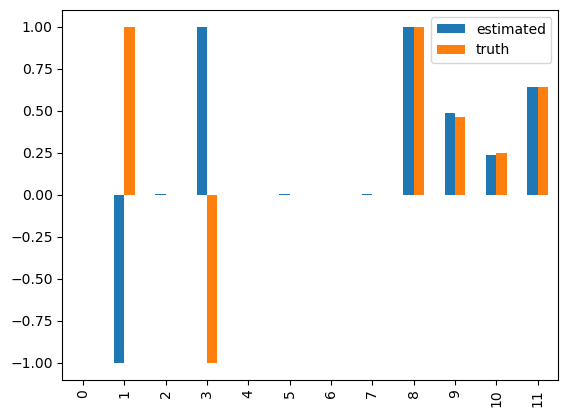

In [6]:
def check_quality_of_icp():
    plant = diagram.GetSubsystemByName("station").GetSubsystemByName("plant")
    plant_context = plant.GetMyContextFromRoot(diagram_context)
    book_frame = plant.GetFrameByName("book")
    X_book = book_frame.CalcPoseInWorld(plant_context)
    Rot_est = X_MS_hat.rotation().matrix().flatten()
    trans_est = X_MS_hat.translation().flatten()
    Rot_truth = X_book.rotation().matrix().flatten()
    trans_truth = X_book.translation().flatten()
    est = np.concatenate([Rot_est,trans_est])
    truth = np.concatenate([Rot_truth,trans_truth])
    pd.DataFrame({"estimated": est, "truth": truth}).plot(kind='bar')
check_quality_of_icp()


### 3.2. Sampling and Evaluting Grasp Poses

In [7]:
def make_internal_model():
    
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
    parser = Parser(plant)
    ConfigureParser(parser)

    parser.AddModelsFromUrl("file:///workspaces/RobotLibrarian/hwstation/objects/library_setup_floating_gripper.dmd.yaml")
    plant.Finalize()

    return builder.Build()

In [8]:
def sample_grasps(cloud: PointCloud, diagram: Diagram, diagram_context: Context):
    rng = np.random.default_rng()
    # Now find grasp poses
    # X_Gs will have the poses to be used for planning when working on that step
    internal_model = make_internal_model()
    internal_model_context = internal_model.CreateDefaultContext()
    costs = []
    X_Gs = []
    for i in range(100 if running_as_notebook else 2):
        cost, X_G = GenerateAntipodalGraspCandidate(
            internal_model, internal_model_context, cloud, rng
        )
        if np.isfinite(cost):
            costs.append(cost)
            X_Gs.append(X_G)

    indices = np.asarray(costs).argsort()[:5]
    min_cost_XGs = []
    for idx in indices:
        min_cost_XGs.append(X_Gs[idx])

    #Get the antipodal grasp that is closest to the robot WSG frame:
    positions = np.stack([frame.translation() for frame in min_cost_XGs])

    plant = diagram.GetSubsystemByName("station").GetSubsystemByName("plant")
    plant_context = plant.GetMyContextFromRoot(diagram_context)

    wsg = plant.GetBodyByName("body")
    wsg_body_index = wsg.index()

    wsg_pose = plant.EvalBodyPoseInWorld(plant_context,wsg)
    wsg_position = wsg_pose.translation()

    best_grasp_idx = np.argmin(((positions-wsg_position)**2).sum(axis=1))
    X_G_optim = min_cost_XGs[best_grasp_idx]

    return X_G_optim

In [9]:
optim_grasp = sample_grasps(icp_cloud, diagram, diagram_context)
optim_grasp

RigidTransform(
  R=RotationMatrix([
    [0.9999887422974676, 0.0006434045875001136, -0.004701202916873039],
    [0.004181523390590299, -0.5877887374516176, 0.8090036557316458],
    [-0.002242797463610562, -0.8090142063991028, -0.5877848107121918],
  ]),
  p=[0.4730574204031877, 0.3487323494857475, 0.6760603090062661],
)

## 4. Create Trajectory

In [10]:
from manipulation.pick import *

In [35]:
def get_table_wsg_poses(diagram: Diagram, diagram_context: Context):

    plant = diagram.GetSubsystemByName("station").GetSubsystemByName("plant")
    
    wsg = plant.GetBodyByName("body")
    wsg_body_index = wsg.index()
    plant_context = plant.GetMyContextFromRoot(diagram_context)
    wsg_initial_pose = plant.EvalBodyPoseInWorld(plant_context,wsg)
    
    X_G_dict = {"initial":  wsg_initial_pose, "pick": optim_grasp, "place": wsg_initial_pose}
    
    return X_G_dict

def create_gripper_pose_and_command_trajectories(X_G_dict):
    traj_frames, traj_times = MakeGripperFrames(X_G_dict)
    trajectory = MakeGripperPoseTrajectory(traj_frames,traj_times)
    traj_wsg_command = MakeGripperCommandTrajectory(traj_times)
    return traj_times, trajectory, traj_wsg_command

def create_t_and_pose_list(traj_times, trajectory) -> List[RigidTransform]:
    # max_time = max(traj_times.values())
    max_time = 10.0
    t_lst = np.linspace(0, max_time, 30)
    pose_lst = []
    for t in t_lst:
        #AddMeshcatTriad(meshcat, path=str(t), X_PT=InterpolatePose(t), opacity=0.2)
        pose_lst.append(RigidTransform(trajectory.value(t)))
    return t_lst, pose_lst
def create_q_knots(pose_lst: List[RigidTransform], t_lst: np.ndarray, diagram: Context, diagram_context: Context):
    """Convert end-effector pose list to joint position list using series of
    InverseKinematics problems. Note that q is 12-dimensional because the first 3 dimensions are the base
    and the last 2 contain gripper joints.
    @param: pose_lst (python list): post_lst[i] contains keyframe X_WG at index i.
    @return: q_knots (python_list): q_knots[i] contains IK solution that will give f(q_knots[i]) \approx pose_lst[i].
    """
    plant = diagram.GetSubsystemByName("station").GetSubsystemByName("plant")
    plant_context = plant.GetMyContextFromRoot(diagram_context)

    q_knots = []
    world_frame = plant.world_frame()
    gripper_frame = plant.GetFrameByName("body")
    # can add book as part of ik and set them equal? don't need to constrain, kind of tacky but otherwise we'd have to make another plant

    #Get base transformation
    base_y_body = plant.GetBodyByName("base_y")
    base_y_body_index = base_y_body.index()
    base_y_pose = plant.EvalBodyPoseInWorld(plant_context,base_y_body)
    base_trans = base_y_pose.translation()

    q_nominal = np.array(
        [base_trans[0], base_trans[1], base_trans[2], 0.0, 0.6, 0.0, -1.75, 0.0, 1.0, 0.0, 0.0, 0.0]
    )  # nominal joint angles for joint-centering.
    q_book = np.array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]) # would need one of these per book
    q_nominal = np.hstack((q_nominal, q_book))

    def AddOrientationConstraint(ik, R_WG, bounds):
        """Add orientation constraint to the ik problem. Implements an inequality
        constraint where the axis-angle difference between f_R(q) and R_WG must be
        within bounds. Can be translated to:
        ik.prog().AddBoundingBoxConstraint(angle_diff(f_R(q), R_WG), -bounds, bounds)
        """
        ik.AddOrientationConstraint(
            frameAbar=world_frame,
            R_AbarA=R_WG,
            frameBbar=gripper_frame,
            R_BbarB=RotationMatrix(),
            theta_bound=bounds,
        )

    def AddPositionConstraint(ik, p_WG_lower, p_WG_upper):
        """Add position constraint to the ik problem. Implements an inequality
        constraint where f_p(q) must lie between p_WG_lower and p_WG_upper. Can be
        translated to
        ik.prog().AddBoundingBoxConstraint(f_p(q), p_WG_lower, p_WG_upper)
        """
        ik.AddPositionConstraint(
            frameA=world_frame,
            frameB=gripper_frame,
            p_BQ=np.zeros(3),
            p_AQ_lower=p_WG_lower,
            p_AQ_upper=p_WG_upper,
        )

    for i in range(len(pose_lst)):
        print(i)
        ik = inverse_kinematics.InverseKinematics(plant,plant_context=plant_context)
        q_variables = ik.q()  # Get variables for MathematicalProgram
        prog = ik.prog()  # Get MathematicalProgram

        X_WG = pose_lst[i]
        p_WG = X_WG.translation()
        R_WG = X_WG.rotation()
        d = 0.05
        p_WG_adjustment = 0.01*np.array([1.0,1.0,1.0])
        prog.AddConstraint(eq([q_variables[2]], [0]))
        

        AddPositionConstraint(ik, p_WG - p_WG_adjustment, p_WG + p_WG_adjustment)
        AddOrientationConstraint(ik, R_WG, 0.05)
        
        #collision_constraint = MinimumDistanceLowerBoundConstraint(plant,0.001, plant_context)
        ik.AddMinimumDistanceLowerBoundConstraint(bound=-.1)
        # from pydrake.multibody.inverse_kinematics import DistanceConstraint
        # prog.AddConstraint(DistanceConstraint(plant, [geometry_id1, geometry_id2], plant_context, distance_lower, distance_upper), q)
        prog.AddQuadraticErrorCost(np.identity(len(q_variables)), q_nominal, q_variables)
        
        if i == 0:
            prog.SetInitialGuess(q_variables, q_nominal)
        else:
            prog.SetInitialGuess(q_variables, q_knots[i-1])
        
        ################################################

        result = Solve(prog)

        assert result.is_success()

        q_vars = result.GetSolution(q_variables)
        # q_vars = np.hstack((q_vars, np.zeros(8)))
        q_knots.append(q_vars)
    
    q_knots = np.array(q_knots)[:, :10]

    return q_knots

In [12]:
# ik = inverse_kinematics.InverseKinematics(plant,plant_context=plant_context)
# ik.AddMinimumDistanceConstraint(minimum_distance=0.001,plant_context=plant_context)

# ik_context = ik.context()

In [13]:
plant = diagram.GetSubsystemByName("station").GetSubsystemByName("plant")
#plant_context = plant.GetMyContextFromRoot(diagram_context)
# MinimumDistanceLowerBoundConstraint(plant=plant,bound=0.001,plant_context=plant_context)

In [14]:
def create_book_picking_joint_trajectory(diagram: Diagram, diagram_context: Context, optim_grasp: RigidTransform):
    
    X_G_dict = get_table_wsg_poses(diagram, diagram_context)
    traj_times, trajectory, traj_wsg_command = create_gripper_pose_and_command_trajectories(X_G_dict)
    t_lst, pose_lst = create_t_and_pose_list(traj_times, trajectory)
    q_knots = create_q_knots(pose_lst, t_lst, diagram, diagram_context)
    q_traj = PiecewisePolynomial.CubicShapePreserving(t_lst, q_knots.T)
    
    return q_traj, t_lst, q_knots, traj_wsg_command

def plot_joint_commands(q_knots):
    import pandas as pd
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(9,9))
    pd.DataFrame(q_knots,columns=plant.GetActuatorNames()).plot(ax=ax)

In [15]:
#visualize_diagram(diagram)

In [16]:
q_traj, t_lst, q_knots, traj_wsg_command = create_book_picking_joint_trajectory(diagram, diagram_context, optim_grasp)
#plot_joint_commands(q_knots)

0
1
2
3
4
5
6
7
8
9
10


11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


AssertionError: 

## 5. Try to execute trajectory (FAILS SO FAR)

In [11]:
from manipulation.station import MakeHardwareStation, load_scenario
from manipulation.station import AddPointClouds

In [12]:
# scenario_data = get_library_scenario_data()
# meshcat.Delete()
# builder = DiagramBuilder()
# scenario = load_scenario(data=scenario_data)
# station = builder.AddSystem(MakeHardwareStation(scenario, meshcat,parser_preload_callback=ConfigureParser))

# # Adding point cloud extractors:
# to_point_cloud = AddPointClouds(
#     scenario=scenario, station=station, builder=builder, meshcat=meshcat
# )

# #Connect point clouds with output port:
# for idx, name in enumerate(to_point_cloud.keys()):
#     builder.ExportOutput(
#         to_point_cloud[name].get_output_port(), name+"_ptcloud")

# builder.ExportOutput(
#     station.GetOutputPort("mobile_iiwa.state_estimated"),
#     "mobile_iiwa.state_estimated"
# )

# # builder.ExportInput(
# #     station.GetInputPort("mobile_iiwa.desired_state"),
# #     "mobile_iiwa.desired_state"
# # )

# q_traj_system = builder.AddSystem(TrajectorySource(q_traj))
# g_traj_system = builder.AddSystem(TrajectorySource(traj_wsg_command))

# state_interpolator = builder.AddSystem(StateInterpolatorWithDiscreteDerivative(num_positions=10, time_step=0.1))

# # builder.Connect(
# #     q_traj_system.get_output_port(), station.GetInputPort("mobile_iiwa.desired_state")
# # )

# builder.Connect(
#     q_traj_system.get_output_port(), state_interpolator.GetInputPort("position")
# )

# builder.Connect(
#     state_interpolator.GetOutputPort("state"), station.GetInputPort("mobile_iiwa.desired_state")
# )

# builder.Connect(
#     g_traj_system.get_output_port(), station.GetInputPort("wsg.position")
# )


# visualizer = MeshcatVisualizer.AddToBuilder(builder, station.GetOutputPort("query_object"), meshcat)
# diagram = builder.Build()
# diagram.set_name("plant and scene_graph")
# simulator = Simulator(diagram)
# #fix_input_port(diagram, simulator)
# #visualizer.StartRecording(False)
# simulator.AdvanceTo(10.0)


# # save this to a python script and try running that
#     # try running with gdb python to see what line it died on
#     # valgrind could help show what memory leaks or seg faults there are
#     # maybe a divide by zero
#     # if still issue ask Russ

In [20]:
class ManipulationStationSim:
    def __init__(self, diagram: Diagram, diagram_context: Context):
        self.diagram = diagram
        self.station = diagram.GetSubsystemByName("station")
        self.plant = self.station.GetSubsystemByName("plant")
        self.scene_graph = self.station.GetSubsystemByName("scene_graph")

        # scene graph query output port.
        self.query_output_port = self.scene_graph.GetOutputPort("query")

        # contexts
        self.context_diagram = diagram_context
        self.context_station = self.diagram.GetSubsystemContext(
            self.station, self.context_diagram
        )
        self.context_scene_graph = self.station.GetSubsystemContext(
            self.scene_graph, self.context_station
        )
        self.context_plant = self.station.GetMutableSubsystemContext(
            self.plant, self.context_station
        )
        # # mark initial configuration
        # self.q0 = self.plant.GetPositions(
        #     self.context_plant, self.plant.GetModelInstanceByName("mobile_iiwa")
        # )

    def SetStationConfiguration(
        self, q_iiwa, gripper_setpoint
    ):
        """
        :param q_iiwa: (10,) numpy array, base pos and joint angle of robots in radian.
        :param gripper_setpoint: float, gripper opening distance in meters.
        :return:
        """
        self.plant.SetPositions(
            self.context_plant,
            self.plant.GetModelInstanceByName("mobile_iiwa"),
            q_iiwa,
        )
        self.plant.SetPositions(
            self.context_plant,
            self.plant.GetModelInstanceByName("wsg"),
            [-gripper_setpoint / 2, gripper_setpoint / 2],
        )

    def ExistsCollision(
        self, q_iiwa, gripper_setpoint):
        self.SetStationConfiguration(
            q_iiwa, gripper_setpoint
        )
        query_object = self.query_output_port.Eval(self.context_scene_graph)
        collision_pairs = query_object.ComputePointPairPenetration()
    
        return len(collision_pairs) > 0

In [21]:
scenario_data = get_library_scenario_data()
meshcat.Delete()
builder = DiagramBuilder()
scenario = load_scenario(data=scenario_data)
station = builder.AddSystem(MakeHardwareStation(scenario, meshcat,parser_preload_callback=ConfigureParser))

# Adding point cloud extractors:
to_point_cloud = AddPointClouds(
    scenario=scenario, station=station, builder=builder, meshcat=meshcat
)

manipSim = ManipulationStationSim(diagram, diagram_context)

In [22]:
from rrt_planner_helpers.rrt_planning import (
    Problem,
)
from rrt_planner_helpers.robot import (
    ConfigurationSpace,
    Range,
)

In [23]:
class IiwaProblem(Problem):
    def __init__(
        self,
        q_start: np.array,
        q_goal: np.array,
        gripper_setpoint: float,
        collision_checker: ManipulationStationSim,
    ):
        self.gripper_setpoint = gripper_setpoint
        self.collision_checker = collision_checker
        plant = self.collision_checker.plant
        nq = 10
        joint_limits = np.zeros((nq, 2))
        
        #DEBUG: remove z
        for idx,joint_char in enumerate(["x","y","z"]):
            joint = plant.GetJointByName("iiwa_base_"+joint_char)
            joint_limits[idx, 0] = joint.position_lower_limits()
            joint_limits[idx, 1] = joint.position_upper_limits()
        
        # joint = plant.GetJointByName("iiwa_joint_z")
        # joint_limits[2, 0] = 0.0
        # joint_limits[2, 1] = 0.0

        for i in range(3,nq):
            joint = plant.GetJointByName("iiwa_joint_%i" % (i-2))
            joint_limits[i, 0] = joint.position_lower_limits()
            joint_limits[i, 1] = joint.position_upper_limits()

        range_list = []
        for joint_limit in joint_limits:
            range_list.append(Range(joint_limit[0], joint_limit[1]))
        #print(range_list)
        def l2_distance(q: tuple):
            sum = 0
            for q_i in q:
                sum += q_i**2
            return np.sqrt(sum)
        self.joint_limits = joint_limits
        max_steps = nq * [np.pi / 180 * 2]  # three degrees
        cspace_iiwa = ConfigurationSpace(range_list, l2_distance, max_steps)
        
        #self.cspace_iiwa = cspace_iiwa
        #Call base class constructor.
        Problem.__init__(
            self,
            x=10,  # not used.
            y=10,  # not used.
            robot=None,  # not used.
            obstacles=None,  # not used.
            start=tuple(q_start),
            goal=tuple(q_goal),
            cspace=cspace_iiwa,
        )

    def collide(self, configuration):
        q = np.array(configuration)
        return self.collision_checker.ExistsCollision(
            q,
            self.gripper_setpoint,
        )

In [24]:

class IKSolver(object):
    def __init__(self):

        # setup controller plant
        plant_mobile_iiwa = MultibodyPlant(0.0)
        iiwa_file = "file:///workspaces/RobotLibrarian/hwstation/objects/mobile_iiwa14_primitive_collision.urdf"
        iiwa = Parser(plant_mobile_iiwa).AddModelsFromUrl(iiwa_file)[0]

        # Define frames
        L0 = plant_mobile_iiwa.GetFrameByName("base")
        l7_frame = plant_mobile_iiwa.GetFrameByName("iiwa_link_7")
        world_frame = plant_mobile_iiwa.world_frame()
        plant_mobile_iiwa.WeldFrames(world_frame, L0)
        plant_mobile_iiwa.Finalize()
        plant_mobile_context = plant_mobile_iiwa.CreateDefaultContext()

        # gripper in link 7 frame
        X_L7G = RigidTransform(
            rpy=RollPitchYaw([np.pi / 2, 0, np.pi / 2]), p=[0, 0, 0.114]
        )
        world_frame = plant_mobile_iiwa.world_frame()

        self.world_frame = world_frame
        self.l7_frame = l7_frame
        self.plant_iiwa = plant_mobile_iiwa
        self.plant_context = plant_mobile_context
        self.X_L7G = X_L7G

    def solve(self, X_WT, q_guess=None, theta_bound=0.01, position_bound=0.01):
        """
        plant: a mini plant only consists of iiwa arm with no gripper attached
        X_WT: transform of target frame in world frame
        q_guess: a guess on the joint state sol
        """
        plant_mobile_iiwa = self.plant_iiwa
        l7_frame = self.l7_frame
        X_L7G = self.X_L7G
        world_frame = self.world_frame

        R_WT = X_WT.rotation()
        p_WT = X_WT.translation()

        if q_guess is None:
            q_guess = np.zeros(10)

        ik_instance = inverse_kinematics.InverseKinematics(plant_mobile_iiwa)
        # align frame A to frame B
        ik_instance.AddOrientationConstraint(
            frameAbar=l7_frame,
            R_AbarA=X_L7G.rotation(),
            #   R_AbarA=RotationMatrix(), # for link 7
            frameBbar=world_frame,
            R_BbarB=R_WT,
            theta_bound=position_bound,
        )
        # align point Q in frame B to the bounding box in frame A
        ik_instance.AddPositionConstraint(
            frameB=l7_frame,
            p_BQ=X_L7G.translation(),
            # p_BQ=[0,0,0], # for link 7
            frameA=world_frame,
            p_AQ_lower=p_WT - position_bound,
            p_AQ_upper=p_WT + position_bound,
        )
        prog = ik_instance.prog()
        prog.SetInitialGuess(ik_instance.q(), q_guess)
        result = Solve(prog)
        if result.get_solution_result() != SolutionResult.kSolutionFound:
            return result.GetSolution(ik_instance.q()), False
        return result.GetSolution(ik_instance.q()), True

In [26]:
plant = diagram.GetSubsystemByName("station").GetSubsystemByName("plant")
plant_context = plant.GetMyContextFromRoot(diagram_context)
q0 = plant.GetPositions(
            plant_context, plant.GetModelInstanceByName("mobile_iiwa")
        )

ik_solver = IKSolver()
q_goal, optimal = ik_solver.solve(optim_grasp, q_guess=q0)

In [27]:
gripper_setpoint = 0.1

#  IF THIS FAILS NEED TO RERUN ICP AND GET A NEW OPTIMAL GRASP
iiwa_problem = IiwaProblem(
    q_start=q0,
    q_goal=q_goal,
    gripper_setpoint=gripper_setpoint,
    collision_checker=manipSim
)

In [28]:
from random import random

In [29]:
class TreeNode:
    def __init__(self, value, parent=None):
        self.value = value  # tuple of floats representing a configuration
        self.parent = parent  # another TreeNode
        self.children = []  # list of TreeNodes

class RRT:
    """
    RRT Tree.
    """

    def __init__(self, root: TreeNode, cspace: ConfigurationSpace):
        self.root = root  # root TreeNode
        self.cspace = cspace  # robot.ConfigurationSpace
        self.size = 1  # int length of path
        self.max_recursion = 1000  # int length of longest possible path

    def add_configuration(self, parent_node, child_value):
        child_node = TreeNode(child_value, parent_node)
        parent_node.children.append(child_node)
        self.size += 1
        return child_node

    # Brute force nearest, handles general distance functions
    def nearest(self, configuration):
        """
        Finds the nearest node by distance to configuration in the
             configuration space.

        Args:
            configuration: tuple of floats representing a configuration of a
                robot

        Returns:
            closest: TreeNode. the closest node in the configuration space
                to configuration
            distance: float. distance from configuration to closest
        """

        configuration = np.nan_to_num(configuration) # had to add this line to make it work
        assert self.cspace.valid_configuration(configuration)

        def recur(node, depth=0):
            closest, distance = node, self.cspace.distance(
                node.value, configuration
            )
            if depth < self.max_recursion:
                for child in node.children:
                    (child_closest, child_distance) = recur(child, depth + 1)
                    if child_distance < distance:
                        closest = child_closest
                        child_distance = child_distance
            return closest, distance

        return recur(self.root)[0]

In [30]:
class RRT_tools:
    def __init__(self, problem):
        # rrt is a tree
        self.rrt_tree = RRT(TreeNode(problem.start), problem.cspace)
        problem.rrts = [self.rrt_tree]
        self.problem = problem

    def find_nearest_node_in_RRT_graph(self, q_sample):
        nearest_node = self.rrt_tree.nearest(q_sample)
        return nearest_node

    def sample_node_in_configuration_space(self):
        q_sample = self.problem.cspace.sample()
        return q_sample

    def calc_intermediate_qs_wo_collision(self, q_start, q_end):
        """create more samples by linear interpolation from q_start
        to q_end. Return all samples that are not in collision

        Example interpolated path:
        q_start, qa, qb, (Obstacle), qc , q_end
        returns >>> q_start, qa, qb
        """
        return self.problem.safe_path(q_start, q_end)

    def grow_rrt_tree(self, parent_node, q_sample):
        """
        add q_sample to the rrt tree as a child of the parent node
        returns the rrt tree node generated from q_sample
        """
        child_node = self.rrt_tree.add_configuration(parent_node, q_sample)
        return child_node

    def node_reaches_goal(self, node):
        return node.value == self.problem.goal

    def backup_path_from_node(self, node):
        path = [node.value]
        while node.parent is not None:
            node = node.parent
            path.append(node.value)
        path.reverse()
        return path

In [31]:
def rrt_planning(problem, max_iterations=1000, prob_sample_q_goal=0.05):
    """
    Input:
        problem (IiwaProblem): instance of a utility class
        max_iterations: the maximum number of samples to be collected
        prob_sample_q_goal: the probability of sampling q_goal

    Output:
        path (list): [q_start, ...., q_goal].
                    Note q's are configurations, not RRT nodes
    """
    rrt_tools = RRT_tools(iiwa_problem)
    q_goal = problem.goal
    q_start = problem.start

    for k in range(max_iterations):
        q_sample = rrt_tools.sample_node_in_configuration_space()
        rand = random()
        if rand < prob_sample_q_goal:
            q_sample = q_goal
        nearest_node = rrt_tools.find_nearest_node_in_RRT_graph(q_sample)
        q_list = rrt_tools.calc_intermediate_qs_wo_collision(nearest_node.value, q_sample)

        last_node = nearest_node
        for q_i in q_list:
            last_node = rrt_tools.grow_rrt_tree(last_node, q_i)
        

        path_found = rrt_tools.node_reaches_goal(last_node)
        if hasattr(path_found, "__len__"):
            path_found = all(rrt_tools.node_reaches_goal(last_node))
        
        if path_found:
            path = rrt_tools.backup_path_from_node(last_node)
            return path

    return None

In [39]:
path = rrt_planning(iiwa_problem, 600, 0.05)

In [40]:
print(path)

[(1.0, 1.5, 0.0, -1.57, 0.1, 0.0, -1.2, 0.0, 1.6, 0.0), array([ 1.  ,  1.5 ,  0.  , -1.57,  0.1 ,  0.  , -1.2 ,  0.  ,  1.6 ,
        0.  ]), (0.9668085093975405, 1.4639179357369558, 0.0, -1.5745850682651155, 0.11192707875904918, -0.0011087168942995225, -1.1926442794230792, 0.004603693327879676, 1.5700383586026123, -0.006641228997319924), (0.933617018795081, 1.4278358714739119, 0.0, -1.5791701365302306, 0.12385415751809838, -0.002217433788599045, -1.1852885588461586, 0.009207386655759353, 1.5400767172052243, -0.013282457994639847), (0.9004255281926214, 1.3917538072108677, 0.0, -1.583755204795346, 0.13578123627714755, -0.0033261506828985675, -1.1779328382692378, 0.013811079983639028, 1.5101150758078365, -0.01992368699195977), (0.8672340375901619, 1.3556717429478236, 0.0, -1.5883402730604612, 0.14770831503619675, -0.00443486757719809, -1.1705771176923172, 0.018414773311518706, 1.4801534344104486, -0.026564915989279694), (0.8340425469877024, 1.3195896786847796, 0.0, -1.5929253413255766, 0

In [41]:
max_time = 5.0
t_lst = np.linspace(0, max_time, len(path))
q_traj = PiecewisePolynomial.CubicShapePreserving(t_lst, np.array(path).T)

# just trying to have a gripper trajectory so I can run this (this line breaks when trying to rerun because the context is gone so we'll need something better)
X_G_dict = get_table_wsg_poses(diagram, diagram_context)
traj_times, trajectory, traj_wsg_command = create_gripper_pose_and_command_trajectories(X_G_dict)

RuntimeError: A function call on a drake::systems::Diagram<double> system named '::plant and scene_graph' was passed the Context of a system named '::_' instead of the appropriate subsystem Context.
For more information about Context-System mismatches, see https://drake.mit.edu/troubleshooting.html#framework-context-system-mismatch

In [42]:
scenario_data = get_library_scenario_data()
meshcat.Delete()
builder = DiagramBuilder()
scenario = load_scenario(data=scenario_data)
station = builder.AddSystem(MakeHardwareStation(scenario, meshcat,parser_preload_callback=ConfigureParser))

# Adding point cloud extractors:
to_point_cloud = AddPointClouds(
    scenario=scenario, station=station, builder=builder, meshcat=meshcat
)

#Connect point clouds with output port:
for idx, name in enumerate(to_point_cloud.keys()):
    builder.ExportOutput(
        to_point_cloud[name].get_output_port(), name+"_ptcloud")

builder.ExportOutput(
    station.GetOutputPort("mobile_iiwa.state_estimated"),
    "mobile_iiwa.state_estimated"
)

# builder.ExportInput(
#     station.GetInputPort("mobile_iiwa.desired_state"),
#     "mobile_iiwa.desired_state"
# )

q_traj_system = builder.AddSystem(TrajectorySource(q_traj))
g_traj_system = builder.AddSystem(TrajectorySource(traj_wsg_command))

state_interpolator = builder.AddSystem(StateInterpolatorWithDiscreteDerivative(num_positions=10, time_step=0.1))

# builder.Connect(
#     q_traj_system.get_output_port(), station.GetInputPort("mobile_iiwa.desired_state")
# )

builder.Connect(
    q_traj_system.get_output_port(), state_interpolator.GetInputPort("position")
)

builder.Connect(
    state_interpolator.GetOutputPort("state"), station.GetInputPort("mobile_iiwa.desired_state")
)

builder.Connect(
    g_traj_system.get_output_port(), station.GetInputPort("wsg.position")
)


visualizer = MeshcatVisualizer.AddToBuilder(builder, station.GetOutputPort("query_object"), meshcat)
diagram = builder.Build()
diagram.set_name("plant and scene_graph")
simulator = Simulator(diagram)
#fix_input_port(diagram, simulator)
#visualizer.StartRecording(False)
simulator.AdvanceTo(10.0)

## CODE BELOW THIS POINT IS EXPERIMENTAL

In [61]:
# from hwstation.utils import visualize_diagram
# visualize_diagram(diagram)
# builder, plant, scene_graph, station, parser, scenario = setup_builder(meshcat, scenario_data=scenario_data)
# parser.AddModelsFromUrl("file:///workspaces/RobotLibrarian/hwstation/objects/mobile_iiwa.dmd.yaml")

In [ ]:
y_bin_grasp_selector = builder.AddSystem(
    GraspSelector(
        plant,
        plant.GetModelInstanceByName("bin0"),
        camera_body_indices=[
            plant.GetBodyIndices(plant.GetModelInstanceByName("camera0"))[
                0
            ],
            plant.GetBodyIndices(plant.GetModelInstanceByName("camera1"))[
                0
            ],
            plant.GetBodyIndices(plant.GetModelInstanceByName("camera2"))[
                0
            ],
        ],
    )
)
builder.Connect(
    to_point_cloud["camera0"].get_output_port(),
    y_bin_grasp_selector.get_input_port(0),
)
builder.Connect(
    to_point_cloud["camera1"].get_output_port(),
    y_bin_grasp_selector.get_input_port(1),
)
builder.Connect(
    to_point_cloud["camera2"].get_output_port(),
    y_bin_grasp_selector.get_input_port(2),
)
builder.Connect(
    station.GetOutputPort("body_poses"),
    y_bin_grasp_selector.GetInputPort("body_poses"),
)

x_bin_grasp_selector = builder.AddSystem(
    GraspSelector(
        plant,
        plant.GetModelInstanceByName("bin1"),
        camera_body_indices=[
            plant.GetBodyIndices(plant.GetModelInstanceByName("camera3"))[
                0
            ],
            plant.GetBodyIndices(plant.GetModelInstanceByName("camera4"))[
                0
            ],
            plant.GetBodyIndices(plant.GetModelInstanceByName("camera5"))[
                0
            ],
        ],
    )
)
builder.Connect(
    to_point_cloud["camera3"].get_output_port(),
    x_bin_grasp_selector.get_input_port(0),
)
builder.Connect(
    to_point_cloud["camera4"].get_output_port(),
    x_bin_grasp_selector.get_input_port(1),
)
builder.Connect(
    to_point_cloud["camera5"].get_output_port(),
    x_bin_grasp_selector.get_input_port(2),
)
builder.Connect(
    station.GetOutputPort("body_poses"),
    x_bin_grasp_selector.GetInputPort("body_poses"),
)

planner = builder.AddSystem(Planner(plant))
builder.Connect(
    station.GetOutputPort("body_poses"), planner.GetInputPort("body_poses")
)
builder.Connect(
    x_bin_grasp_selector.get_output_port(),
    planner.GetInputPort("x_bin_grasp"),
)
builder.Connect(
    y_bin_grasp_selector.get_output_port(),
    planner.GetInputPort("y_bin_grasp"),
)
builder.Connect(
    station.GetOutputPort("wsg.state_measured"),
    planner.GetInputPort("wsg_state"),
)
builder.Connect(
    station.GetOutputPort("iiwa.position_measured"),
    planner.GetInputPort("iiwa_position"),
)

robot = station.GetSubsystemByName(
    "iiwa.controller"
).get_multibody_plant_for_control()

# Set up differential inverse kinematics.
diff_ik = AddIiwaDifferentialIK(builder, robot)
builder.Connect(planner.GetOutputPort("X_WG"), diff_ik.get_input_port(0))
builder.Connect(
    station.GetOutputPort("iiwa.state_estimated"),
    diff_ik.GetInputPort("robot_state"),
)
builder.Connect(
    planner.GetOutputPort("reset_diff_ik"),
    diff_ik.GetInputPort("use_robot_state"),
)

builder.Connect(
    planner.GetOutputPort("wsg_position"),
    station.GetInputPort("wsg.position"),
)

# The DiffIK and the direct position-control modes go through a PortSwitch
switch = builder.AddSystem(PortSwitch(7))
builder.Connect(
    diff_ik.get_output_port(), switch.DeclareInputPort("diff_ik")
)
builder.Connect(
    planner.GetOutputPort("iiwa_position_command"),
    switch.DeclareInputPort("position"),
)
builder.Connect(
    switch.get_output_port(), station.GetInputPort("iiwa.position")
)
builder.Connect(
    planner.GetOutputPort("control_mode"),
    switch.get_port_selector_input_port(),
)

visualizer = MeshcatVisualizer.AddToBuilder(
    builder, station.GetOutputPort("query_object"), meshcat
)
diagram = builder.Build()

In [180]:
def BuildAndSimulateTrajectory(q_traj, g_traj, duration=0.01):
    """Simulate trajectory for manipulation station.
    @param q_traj: Trajectory class used to initialize TrajectorySource for joints.
    @param g_traj: Trajectory class used to initialize TrajectorySource for gripper.
    """
    builder = DiagramBuilder()
    print("MakeManipulationStation")
    station = builder.AddSystem(
        MakeManipulationStation(
            filename="file:///workspaces/RobotLibrarian/hwstation/objects/library_setup.dmd.yaml",
            time_step=1e-3,
            iiwa_prefix="mobile_iiwa",
            wsg_prefix="wsg",
        )
    )
    print("Get plant")
    plant = station.GetSubsystemByName("plant")
    scene_graph = station.GetSubsystemByName("scene_graph")
    AddMultibodyTriad(plant.GetFrameByName("body"), scene_graph)

    print("Adding systems")
    q_traj_system = builder.AddSystem(TrajectorySource(q_traj))
    g_traj_system = builder.AddSystem(TrajectorySource(g_traj))

    print("Visualizer")
    visualizer = MeshcatVisualizer.AddToBuilder(
        builder,
        station.GetOutputPort("query_object"),
        meshcat,
        MeshcatVisualizerParams(delete_on_initialization_event=False),
    )

    print("Builder connect")
    builder.Connect(
        q_traj_system.get_output_port(), station.GetInputPort("iiwa_position")
    )
    builder.Connect(
        g_traj_system.get_output_port(), station.GetInputPort("wsg_position")
    )
    print("builder.Build()")
    diagram = builder.Build()


In [181]:
# def BuildAndSimulateTrajectory(q_traj, g_traj, duration=0.01):
#     """Simulate trajectory for manipulation station.
#     @param q_traj: Trajectory class used to initialize TrajectorySource for joints.
#     @param g_traj: Trajectory class used to initialize TrajectorySource for gripper.
#     """
#     AddMultibodyTriad(plant.GetFrameByName("body"), scene_graph)

#     q_traj_system = builder.AddSystem(TrajectorySource(q_traj))
#     g_traj_system = builder.AddSystem(TrajectorySource(g_traj))

#     visualizer = MeshcatVisualizer.AddToBuilder(
#         builder,
#         station.GetOutputPort("query_object"),
#         meshcat,
#         MeshcatVisualizerParams(delete_on_initialization_event=False),
#     )

#     builder.Connect(
#         q_traj_system.get_output_port(), station.GetInputPort("iiwa_position")
#     )
#     builder.Connect(
#         g_traj_system.get_output_port(), station.GetInputPort("wsg_position")
#     )

#     diagram = builder.Build()

#     simulator = Simulator(diagram)
#     visualizer.StartRecording(False)
#     simulator.AdvanceTo(duration)
#     visualizer.PublishRecording()

#     return simulator, plant

In [182]:
q_knots = np.array(q_knots)
q_traj = PiecewisePolynomial.CubicShapePreserving(t_lst, q_knots[:, :10].T)
simulator, station_plant = BuildAndSimulateTrajectory(q_traj, traj_wsg_command, 11.0)

MakeManipulationStation


SystemExit: Failure at systems/controllers/inverse_dynamics_controller.cc:41 in SetUp(): condition 'num_positions == dim' failed.

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
base_trans = base_y_pose.translation()

array([1. , 1.5, 0. ])

In [ ]:
def BuildAndSimulateTrajectory(q_traj, g_traj, duration=0.01):
    """Simulate trajectory for manipulation station.
    @param q_traj: Trajectory class used to initialize TrajectorySource for joints.
    @param g_traj: Trajectory class used to initialize TrajectorySource for gripper.
    """
    builder = DiagramBuilder()
    station = builder.AddSystem(
        MakeManipulationStation(
            filename="package://manipulation/manipulation_station_with_cupboard.dmd.yaml",
            time_step=1e-3,
        )
    )
    plant = station.GetSubsystemByName("plant")
    scene_graph = station.GetSubsystemByName("scene_graph")
    AddMultibodyTriad(plant.GetFrameByName("body"), scene_graph)

    q_traj_system = builder.AddSystem(TrajectorySource(q_traj))
    g_traj_system = builder.AddSystem(TrajectorySource(g_traj))

    visualizer = MeshcatVisualizer.AddToBuilder(
        builder,
        station.GetOutputPort("query_object"),
        meshcat,
        MeshcatVisualizerParams(delete_on_initialization_event=False),
    )

    builder.Connect(
        q_traj_system.get_output_port(), station.GetInputPort("iiwa_position")
    )
    builder.Connect(
        g_traj_system.get_output_port(), station.GetInputPort("wsg_position")
    )

    diagram = builder.Build()

    simulator = Simulator(diagram)
    visualizer.StartRecording(False)
    simulator.AdvanceTo(duration)
    visualizer.PublishRecording()

    return simulator, plant

In [41]:
class PlannerState(Enum):
    WAIT_FOR_OBJECTS_TO_SETTLE = 1
    PICKING_BOOK_FROM_TABLE = 2
    GOING_TO_SHELF = 3
    PLACING_BOOK_ON_SHELF = 4
    GO_BACK_TO_TABLE = 5

In [ ]:
class Planner(LeafSystem):
    
    """A Planner system.

    Input Ports:
    - body_poses: RigidTransforms given the desired frame of the gripper
    - table_book_grasp: (cost,RigidTransform) giving the desired frame to grasp a book on the table
    - shelf_book_grasp: (cost, RididTransform) giving the desired frame to put a book on the shelf
    - wsg_state: a vector of size 2 giving the WSG commands (I supose each fingers position)
    - iiwa_joints: a vector of size 7 for joint positions
    - iiwa_base: a vector of size 2 for x- and y- coordinates of base

    States:
    - self._mode_index: current mode of the planner
    - self._traj_X_G_index: trajectory of gripper frame
    - self._traj_wsg_index: command trajectory of WSG fingers?
    - self._times_index: dictionary of times
    - self._attempts_index: attempts of grasping something

    Output ports:
    - 
    -
    -
    """

    def __init__(self, plant):
        LeafSystem.__init__(self)

        self._gripper_body_index = plant.GetBodyByName("body").index()
        
        #********
        #Declare input ports
        #********
        self.DeclareAbstractInputPort(
            "body_poses", AbstractValue.Make([RigidTransform()])
        )
        self._table_book_grasp_index = self.DeclareAbstractInputPort(
            "table_book_grasp", AbstractValue.Make((np.inf, RigidTransform()))
        ).get_index()
        self._shelf_book_grasp_index = self.DeclareAbstractInputPort(
            "shelf_book_grasp", AbstractValue.Make((np.inf, RigidTransform()))
        ).get_index()

        #Declares a vector-valued input port of size 2:
        self._wsg_state_index = self.DeclareVectorInputPort(
            "wsg_state", 2
        ).get_index()

        # For GoHome mode.
        num_iiwa_joints = 7
        self._iiwa_joint_position_index = self.DeclareVectorInputPort(
            "iiwa_joints", num_iiwa_joints
        ).get_index()

        num_iiwa_base_coords = 2
        self._iiwa_base_coords_index = self.DeclareVectorInputPort(
            "iiwa_pos", num_iiwa_base_coords
        ).get_index()

        #********
        #Declare states of the system
        #********

        #Abstract state giving the mode:
        #A Context obtained with CreateDefaultContext() will contain this abstract state 
        #variable initially set to a clone of the model_value given here. The actual concrete 
        # type is always preserved.
        self._mode_index = self.DeclareAbstractState(
            AbstractValue.Make(PlannerState.WAIT_FOR_OBJECTS_TO_SETTLE)
        )
        self._traj_X_G_index = self.DeclareAbstractState(
            AbstractValue.Make(PiecewisePose())
        )
        self._traj_wsg_index = self.DeclareAbstractState(
            AbstractValue.Make(PiecewisePolynomial())
        )
        self._times_index = self.DeclareAbstractState(
            AbstractValue.Make({"initial": 0.0})
        )
        #Declares a discrete state group with num_state_variables state variables, 
        #stored in a BasicVector initialized to be all-zero.
        self._attempts_index = self.DeclareDiscreteState(1)

        #********
        #Declare output ports of the system
        #********
        self.DeclareAbstractOutputPort(
            "X_WG",
            lambda: AbstractValue.Make(RigidTransform()),
            self.CalcGripperPose)

        self.DeclareVectorOutputPort("wsg_position", 1, self.CalcWsgPosition)

        self.DeclareAbstractOutputPort(
            "control_mode",
            lambda: AbstractValue.Make(InputPortIndex(0)),
            self.CalcControlMode,
        )

        self.DeclareAbstractOutputPort(
            "reset_diff_ik",
            lambda: AbstractValue.Make(False),
            self.CalcDiffIKReset,
        )

        self._q0_index = self.DeclareDiscreteState(num_positions)  # for q0
        self._traj_q_index = self.DeclareAbstractState(
            AbstractValue.Make(PiecewisePolynomial())
        )
        #DEBUG: MERGE TWO STATES?
        self.DeclareVectorOutputPort(
            "iiwa_base_command", num_iiwa_base, self.CalcIiwaBase
        )
        self.DeclareVectorOutputPort(
            "iiwa_joint_command", num_iiwa_joints, self.CalcIiwaJoint
        )

        #********
        #Declare initialization
        #********
        self.DeclareInitializationDiscreteUpdateEvent(self.Initialize)

        #********
        #Declare periodic updates
        #********
        # Declares that an UnrestrictedUpdate event should occur periodically and 
        # that it should invoke the Update method every 0.1 second at 0.0 offset
        self.DeclarePeriodicUnrestrictedUpdateEvent(0.1, 0.0, self.Update)

    def Update(self, context, state):
        mode = context.get_abstract_state(int(self._mode_index)).get_value()

        current_time = context.get_time()
        times = context.get_abstract_state(int(self._times_index)).get_value()

        #Wait for objects to settle:
        if mode == PlannerState.WAIT_FOR_OBJECTS_TO_SETTLE:
            if context.get_time() - times["initial"] > 1.0:
                self.Plan(context, state)
            return
        
        elif mode == PlannerState.GO_HOME:
            sys.exit("GOING HOME IS NOT IMPLEMENTED YET.")
            # traj_q = context.get_mutable_abstract_state(
            #     int(self._traj_q_index)
            # ).get_value()
            # if not traj_q.is_time_in_range(current_time):
            #     self.Plan(context, state)
            return

        # If we are between pick and place and the gripper is closed, then
        # we've missed or dropped the object.  Time to replan.
        if (
            current_time > times["postpick"]
            and current_time < times["preplace"]
        ):
            wsg_state = self.get_input_port(self._wsg_state_index).Eval(
                context
            )
            if wsg_state[0] < 0.01:
                attempts = state.get_mutable_discrete_state(
                    int(self._attempts_index)
                ).get_mutable_value()
                if attempts[0] > 5:
                    # If I've failed 5 times in a row, then switch bins.
                    print(
                        "Switching to the other bin after 5 consecutive failed attempts"
                    )
                    attempts[0] = 0
                    if mode == PlannerState.PICKING_FROM_X_BIN:
                        state.get_mutable_abstract_state(
                            int(self._mode_index)
                        ).set_value(PlannerState.PICKING_FROM_Y_BIN)
                    else:
                        state.get_mutable_abstract_state(
                            int(self._mode_index)
                        ).set_value(PlannerState.PICKING_FROM_X_BIN)
                    self.Plan(context, state)
                    return

                attempts[0] += 1
                state.get_mutable_abstract_state(
                    int(self._mode_index)
                ).set_value(PlannerState.WAIT_FOR_OBJECTS_TO_SETTLE)
                times = {"initial": current_time}
                state.get_mutable_abstract_state(
                    int(self._times_index)
                ).set_value(times)
                X_G = self.get_input_port(0).Eval(context)[
                    int(self._gripper_body_index)
                ]
                state.get_mutable_abstract_state(
                    int(self._traj_X_G_index)
                ).set_value(
                    PiecewisePose.MakeLinear(
                        [current_time, np.inf], [X_G, X_G]
                    )
                )
                return

        traj_X_G = context.get_abstract_state(
            int(self._traj_X_G_index)
        ).get_value()
        if not traj_X_G.is_time_in_range(current_time):
            self.Plan(context, state)
            return

        X_G = self.get_input_port(0).Eval(context)[
            int(self._gripper_body_index)
        ]
        # if current_time > 10 and current_time < 12:
        #    self.GoHome(context, state)
        #    return
        if (
            np.linalg.norm(
                traj_X_G.GetPose(current_time).translation()
                - X_G.translation()
            )
            > 0.2
        ):
            # If my trajectory tracking has gone this wrong, then I'd better
            # stop and replan.  TODO(russt): Go home, in joint coordinates,
            # instead.
            self.GoHome(context, state)
            return

    def GoToHomePosition(self, context, state):
        print("Replanning due to large tracking error.")
        state.get_mutable_abstract_state(int(self._mode_index)).set_value(
            PlannerState.GO_TO_HOME_POSITION
        )
        q = self.get_input_port(self._iiwa_position_index).Eval(context)
        q0 = copy(context.get_discrete_state(self._q0_index).get_value())
        q0[0] = q[0]  # Safer to not reset the first joint.

        current_time = context.get_time()
        q_traj = PiecewisePolynomial.FirstOrderHold(
            [current_time, current_time + 5.0], np.vstack((q, q0)).T
        )
        state.get_mutable_abstract_state(int(self._traj_q_index)).set_value(
            q_traj
        )

    def Plan(self, context, state):
        mode = copy(
            state.get_mutable_abstract_state(int(self._mode_index)).get_value()
        )

        X_G = {
            "initial": self.get_input_port(0).Eval(context)[
                int(self._gripper_body_index)
            ]
        }

        cost = np.inf
        for i in range(5):
            if mode == PlannerState.PICKING_FROM_Y_BIN:
                cost, X_G["pick"] = self.get_input_port(
                    self._y_bin_grasp_index
                ).Eval(context)
                if np.isinf(cost):
                    mode = PlannerState.PICKING_FROM_X_BIN
            else:
                cost, X_G["pick"] = self.get_input_port(
                    self._x_bin_grasp_index
                ).Eval(context)
                if np.isinf(cost):
                    mode = PlannerState.PICKING_FROM_Y_BIN
                else:
                    mode = PlannerState.PICKING_FROM_X_BIN

            if not np.isinf(cost):
                break

        assert not np.isinf(
            cost
        ), "Could not find a valid grasp in either bin after 5 attempts"
        state.get_mutable_abstract_state(int(self._mode_index)).set_value(mode)

        # TODO(russt): The randomness should come in through a random input
        # port.
        if mode == PlannerState.PICKING_FROM_X_BIN:
            # Place in Y bin:
            X_G["place"] = RigidTransform(
                RollPitchYaw(-np.pi / 2, 0, 0),
                [rng.uniform(-0.25, 0.15), rng.uniform(-0.6, -0.4), 0.3],
            )
        else:
            # Place in X bin:
            X_G["place"] = RigidTransform(
                RollPitchYaw(-np.pi / 2, 0, np.pi / 2),
                [rng.uniform(0.35, 0.65), rng.uniform(-0.12, 0.28), 0.3],
            )

        X_G, times = MakeGripperFrames(X_G, t0=context.get_time())
        print(
            f"Planned {times['postplace'] - times['initial']} second trajectory in mode {mode} at time {context.get_time()}."
        )
        state.get_mutable_abstract_state(int(self._times_index)).set_value(
            times
        )

        if False:  # Useful for debugging
            AddMeshcatTriad(meshcat, "X_Oinitial", X_PT=X_O["initial"])
            AddMeshcatTriad(meshcat, "X_Gprepick", X_PT=X_G["prepick"])
            AddMeshcatTriad(meshcat, "X_Gpick", X_PT=X_G["pick"])
            AddMeshcatTriad(meshcat, "X_Gplace", X_PT=X_G["place"])

        traj_X_G = MakeGripperPoseTrajectory(X_G, times)
        traj_wsg_command = MakeGripperCommandTrajectory(times)

        state.get_mutable_abstract_state(int(self._traj_X_G_index)).set_value(
            traj_X_G
        )
        state.get_mutable_abstract_state(int(self._traj_wsg_index)).set_value(
            traj_wsg_command
        )

    def start_time(self, context):
        return (
            context.get_abstract_state(int(self._traj_X_G_index))
            .get_value()
            .start_time()
        )

    def end_time(self, context):
        return (
            context.get_abstract_state(int(self._traj_X_G_index))
            .get_value()
            .end_time()
        )

    def CalcGripperPose(self, context, output):
        context.get_abstract_state(int(self._mode_index)).get_value()

        traj_X_G = context.get_abstract_state(
            int(self._traj_X_G_index)
        ).get_value()
        if traj_X_G.get_number_of_segments() > 0 and traj_X_G.is_time_in_range(
            context.get_time()
        ):
            # Evaluate the trajectory at the current time, and write it to the
            # output port.
            output.set_value(
                context.get_abstract_state(int(self._traj_X_G_index))
                .get_value()
                .GetPose(context.get_time())
            )
            return

        # Command the current position (note: this is not particularly good if the velocity is non-zero)
        output.set_value(
            self.get_input_port(0).Eval(context)[int(self._gripper_body_index)]
        )

    def CalcWsgPosition(self, context, output):
        mode = context.get_abstract_state(int(self._mode_index)).get_value()
        opened = np.array([0.107])
        np.array([0.0])

        if mode == PlannerState.GO_HOME:
            # Command the open position
            output.SetFromVector([opened])
            return

        traj_wsg = context.get_abstract_state(
            int(self._traj_wsg_index)
        ).get_value()
        if traj_wsg.get_number_of_segments() > 0 and traj_wsg.is_time_in_range(
            context.get_time()
        ):
            # Evaluate the trajectory at the current time, and write it to the
            # output port.
            output.SetFromVector(traj_wsg.value(context.get_time()))
            return

        # Command the open position
        output.SetFromVector([opened])

    def CalcControlMode(self, context, output):
        mode = context.get_abstract_state(int(self._mode_index)).get_value()

        if mode == PlannerState.GO_HOME:
            output.set_value(InputPortIndex(2))  # Go Home
        else:
            output.set_value(InputPortIndex(1))  # Diff IK

    def CalcDiffIKReset(self, context, output):
        mode = context.get_abstract_state(int(self._mode_index)).get_value()

        if mode == PlannerState.GO_HOME:
            output.set_value(True)
        else:
            output.set_value(False)

    def Initialize(self, context, discrete_state):
        discrete_state.set_value(
            int(self._q0_index),
            self.get_input_port(int(self._iiwa_position_index)).Eval(context),
        )

    def CalcIiwaBase(self, context, output):
        pass #Not implemented yet
        # traj_q = context.get_mutable_abstract_state(
        #     int(self._traj_q_index)
        # ).get_value()

        # output.SetFromVector(traj_q.value(context.get_time()))

    def CalcIiwaJoint(self, context, output):
        traj_q = context.get_mutable_abstract_state(
            int(self._traj_q_index)
        ).get_value()

        output.SetFromVector(traj_q.value(context.get_time()))



In [27]:
# def BuildAndSimulateTrajectory(q_traj, g_traj, duration=0.01):
#     """Simulate trajectory for manipulation station.
#     @param q_traj: Trajectory class used to initialize TrajectorySource for joints.
#     @param g_traj: Trajectory class used to initialize TrajectorySource for gripper.
#     """
#     builder = DiagramBuilder()
#     station = builder.AddSystem(
#         MakeManipulationStation(
#             filename="package://manipulation/manipulation_station_with_cupboard.dmd.yaml",
#             time_step=1e-3,
#         )
#     )
#     plant = station.GetSubsystemByName("plant")
#     scene_graph = station.GetSubsystemByName("scene_graph")
#     AddMultibodyTriad(plant.GetFrameByName("body"), scene_graph)

duration = 1.0
q_traj_system = builder.AddSystem(TrajectorySource(trajectory))
g_traj_system = builder.AddSystem(TrajectorySource(traj_wsg_command))

visualizer = MeshcatVisualizer.AddToBuilder(
    environment_builder,
    environment_station.GetOutputPort("query_object"),
    meshcat,
    MeshcatVisualizerParams(delete_on_initialization_event=False),
)

environment_builder.Connect(
    q_traj_system.get_output_port(), environment_station.GetInputPort("iiwa_position")
)
environment_builder.Connect(
    g_traj_system.get_output_port(), environment_station.GetInputPort("wsg_position")
)

#diagram = environment_builder.Build()

simulator = Simulator(environment)
visualizer.StartRecording(False)
simulator.AdvanceTo(duration)
visualizer.PublishRecording()

SystemExit: Failure at systems/primitives/trajectory_source.cc:25 in TrajectorySource(): condition 'trajectory.cols() == 1' failed.

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [54]:
from pydrake.multibody import inverse_kinematics

In [68]:
max_time = max(traj_times.values())
t_lst = np.linspace(0, max_time, 30)
pose_lst = []
for t in t_lst:
    #AddMeshcatTriad(meshcat, path=str(t), X_PT=InterpolatePose(t), opacity=0.2)
    pose_lst.append(RigidTransform(trajectory.value(t)))

In [94]:
len(ik.q())

19

In [47]:
# def create_q_knots(pose_lst):
#     """Convert end-effector pose list to joint position list using series of
#     InverseKinematics problems. Note that q is 9-dimensional because the last 2 dimensions
#     contain gripper joints, but these should not matter to the constraints.
#     @param: pose_lst (python list): post_lst[i] contains keyframe X_WG at index i.
#     @return: q_knots (python_list): q_knots[i] contains IK solution that will give f(q_knots[i]) \approx pose_lst[i].
#     """
q_knots = []
world_frame = plant.world_frame()
gripper_frame = plant.GetFrameByName("body")
q_nominal = np.array(
    [0.0, 0.0, 0.0, 0.6, 0.0, -1.75, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
)  # nominal joint angles for joint-centering.

def AddOrientationConstraint(ik, R_WG, bounds):
    """Add orientation constraint to the ik problem. Implements an inequality
    constraint where the axis-angle difference between f_R(q) and R_WG must be
    within bounds. Can be translated to:
    ik.prog().AddBoundingBoxConstraint(angle_diff(f_R(q), R_WG), -bounds, bounds)
    """
    ik.AddOrientationConstraint(
        frameAbar=world_frame,
        R_AbarA=R_WG,
        frameBbar=gripper_frame,
        R_BbarB=RotationMatrix(),
        theta_bound=bounds,
    )

def AddPositionConstraint(ik, p_WG_lower, p_WG_upper):
    """Add position constraint to the ik problem. Implements an inequality
    constraint where f_p(q) must lie between p_WG_lower and p_WG_upper. Can be
    translated to
    ik.prog().AddBoundingBoxConstraint(f_p(q), p_WG_lower, p_WG_upper)
    """
    ik.AddPositionConstraint(
        frameA=world_frame,
        frameB=gripper_frame,
        p_BQ=np.zeros(3),
        p_AQ_lower=p_WG_lower,
        p_AQ_upper=p_WG_upper,
    )

for i in range(len(pose_lst)):
    ik = inverse_kinematics.InverseKinematics(environment_plant)
    q_variables = ik.q()  # Get variables for MathematicalProgram
    prog = ik.prog()  # Get MathematicalProgram

    #### Modify here ###############################
    X_WG = pose_lst[i]
    p_WG = X_WG.translation()
    R_WG = X_WG.rotation()
    d = 0.05
    p_WG_adjustment = np.array([0.0, 0.0, d / 2.0])
    #AddPositionConstraint(ik, p_WG - p_WG_adjustment, p_WG + p_WG_adjustment)
    #AddOrientationConstraint(ik, R_WG, 0.05)
    prog.AddQuadraticErrorCost(np.identity(len(q_variables)), q_nominal, q_variables)
    if i == 0:
        prog.SetInitialGuess(q_variables, q_nominal)
    else:
        prog.SetInitialGuess(q_variables, q_knots[i-1])
    
    ################################################

    result = Solve(prog)

    assert result.is_success()

    q_knots.append(result.GetSolution(q_variables))



NameError: name 'pose_lst' is not defined